# Model to Classify Chest X-ray images 

## Environment Set-up in Colab
Importing the required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

Connecting to Google Drive to access the data.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Building the model

In [3]:
 #Import the MobileNetV2 model and discard the 1000 neuron fully-connected layer at the top of the network.
base_model= MobileNetV2(weights='imagenet',include_top=False, input_shape=(224,224,3)) 

#Freeze the layers from MobileNetV2 backbone, since it is already trained on the imagenet data and is only being used as a feature extractor 
#(transfer learning).
for layer in base_model.layers:
    layer.trainable=False

#add dense layers to perform the classification
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128, activation = 'relu')) #dense layer 1
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #final classificaton layer with sigmoid activation



9412608/9406464 [==============================] - 0s 0us/step


Preparing the training data as an image data generator object. The data is accessed from the directory where it is stored. 

In [31]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator=train_datagen.flow_from_directory('gdrive/MyDrive/chest_xray/train',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=10,
                                                 class_mode='binary',
                                                 shuffle=True)

val_generator=val_datagen.flow_from_directory('gdrive/MyDrive/chest_xray/val',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=10,
                                                 class_mode='binary',
                                                 shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Using Adam as optimization method, binary_crossentropy as loss function and accuracy as metrics the model is compiled.

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,422,081
Trainable params: 164,097
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the Model

In [6]:
log_file = model.fit(train_generator, epochs=5, validation_data=val_generator, batch_size=10)

Epoch 1/5
522/522 [==============================] - 1531s 3s/step - loss: 0.1109 - accuracy: 0.9576 - val_loss: 0.2229 - val_accuracy: 0.9375
Epoch 2/5
522/522 [==============================] - 62s 118ms/step - loss: 0.0569 - accuracy: 0.9795 - val_loss: 0.0814 - val_accuracy: 1.0000
Epoch 3/5
522/522 [==============================] - 61s 117ms/step - loss: 0.0564 - accuracy: 0.9787 - val_loss: 0.3208 - val_accuracy: 0.8750
Epoch 4/5
522/522 [==============================] - 61s 117ms/step - loss: 0.0354 - accuracy: 0.9883 - val_loss: 0.2585 - val_accuracy: 0.8750
Epoch 5/5
522/522 [==============================] - 61s 116ms/step - loss: 0.0363 - accuracy: 0.9862 - val_loss: 0.0283 - val_accuracy: 1.0000


### Visualizing training and validation loss and accuracy

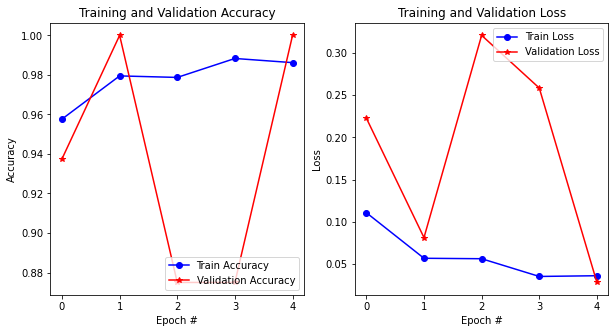

In [63]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(log_file.history['accuracy'], '-bo', label='Train Accuracy')
plt.plot(log_file.history['val_accuracy'], '-r*', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(log_file.history['loss'], '-bo', label='Train Loss')
plt.plot(log_file.history['val_loss'], '-r*', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(loc='upper right')

plt.show()

## Testing Results


In [20]:
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) #included in our dependencies

test_generator=test_datagen.flow_from_directory('gdrive/MyDrive/chest_xray/test',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=10,
                                                 class_mode='binary',
                                                 shuffle=False)

Found 624 images belonging to 2 classes.


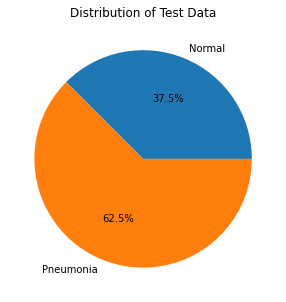

In [61]:
y_test = test_generator.labels
classes , counts = np.unique(y_test, return_counts=True)

plt.figure(figsize=(5,5))
plt.pie(counts,labels=['Normal','Pneumonia'], autopct="%.1f%%")
plt.title('Distribution of Test Data')
plt.show()

The test data is imbalanced. Hence the performance of the algorithm is judged based on precision, recall and f1 score.

In [65]:
preds = model.predict(test_generator)
y_pred = list()
for prob in preds:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.63      0.76       234
           1       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.85      0.84       624



## Saving the model weights

In [64]:
tf.keras.models.save_model(model,'/model/XrayClassification.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
